In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as io
from time import time

import scipy.signal as signal
import scipy
from model.filter import filtfilt
import data.ops

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 10, 5

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

paths = [
    '../validation/TFRecords.TFRecord'
]

In [2]:
fs = 300.

def getconst(constant, **kwargs):
    return tf.constant(constant, dtype=tf.float32, **kwargs)

In [3]:
def rpeakdetect(
    ECG,  # The raw ECG signal
    rate,  # Sampling rate in HZ
    # Window size in seconds to use for
    ransac_window_size=5.0,
    # Low frequency of the band pass filter
    lowfreq=5.0,
    # High frequency of the band pass filter
    highfreq=15.0,
):
    ransac_window_size = int(ransac_window_size * rate)
        
    lowpass = signal.butter(1, highfreq / (rate / 2.0), 'low')
    highpass = signal.butter(1, lowfreq / (rate / 2.0), 'high')
    
    def diff(x):
        return x[:,1:]-x[:,:-1]
    
    with tf.name_scope('lowpass'):
        b_LPF = getconst(lowpass[0])
        a_LPF = getconst(lowpass[1])
        ECG_low = filtfilt(b_LPF, a_LPF, ECG)

    with tf.name_scope('highpass'):
        b_HPF = getconst(highpass[0])
        a_HPF = getconst(highpass[1])
        ECG_band = filtfilt(b_HPF, a_HPF, ECG_low)

    # Square (=signal power) of the first difference of the signal
    with tf.name_scope('diff_power'):
        dECG = diff(ECG_band)
        dECG_power = dECG ** 2
    
    with tf.name_scope('thres_norm_estimation'):
        batch_size = tf.shape(dECG_power)[0]
        sequence_length = tf.shape(dECG_power)[1]
        thresholds = tf.zeros(dtype=tf.float32, shape=[batch_size, 1], name='thresholds_init')
        max_powers = tf.zeros(dtype=tf.float32, shape=[batch_size, 1], name='max_powers_init')
        
        def body(thresholds, max_powers, i):
            d = dECG_power[:, i * ransac_window_size : (i + 1) * ransac_window_size]
            _, var = tf.nn.moments(d,axes=[1], name='variance')
            thresholds = tf.concat([thresholds, 0.5 * tf.sqrt(var)], axis=1, name='concat_thresholds')
            max_value = tf.reduce_max(d, axis=1, name='max')
            max_powers = tf.concat([max_powers, max_value], axis=1, name='concat_max_powers')
            return thresholds, max_powers, i+1

        def cond(thresholds, max_powers, i):
            return i < sequence_length // ransac_window_size

        thresholds, max_powers, _ = tf.while_loop(cond,
                                                  body,
                                                  [thresholds, max_powers, 0],
                                                  shape_invariants=[
                                                      tf.TensorShape([None, None]),
                                                      tf.TensorShape([None, None]),
                                                      tf.TensorShape([])
                                                  ])
        thresholds = thresholds[:,1:]
        max_powers = max_powers[:,1:]
        
        m = (tf.shape(thresholds)[1] + 1)//2
        threshold_list = tf.nn.top_k(thresholds, m, name='calc_treshold').values[:,m-1]
        max_power_list = tf.nn.top_k(max_powers, m, name='median_maxpower').values[:,m-1]
        
    with tf.name_scope('thresholding'):
        shift_mesh = tf.transpose(tf.reshape(tf.tile(threshold_list, [sequence_length]), 
                                             shape=[1,sequence_length,batch_size]), name='shift_mesh')
        dECG_power_shifted = dECG_power - shift_mesh
        dECG_power_thres = tf.where(
            dECG_power_shifted < 0,
            tf.zeros_like(dECG_power),
            dECG_power,
            name='thresholding')

    with tf.name_scope('normalization'):
        scale_mesh = tf.transpose(tf.reshape(tf.tile(max_power_list, [sequence_length]), 
                                             shape=[1,sequence_length,batch_size]), name='scale_mesh')
        dECG_power_thres_norm = dECG_power_thres / scale_mesh
            
        dECG_power_thres_norm = tf.where(
            dECG_power_thres_norm > 1.,
            tf.ones_like(dECG_power_thres_norm),
            dECG_power_thres_norm,
            name='cut_off_high_values')
        dECG_power_thres_norm_square = dECG_power_thres_norm ** 2

        
    with tf.name_scope('average_smoothing'):
        # Average smoothing
        mean_window_len = int(rate * 0.125 + 1)
        kernel = [1.0 / mean_window_len] * mean_window_len
        avg_kernel = tf.constant(kernel, shape=[mean_window_len, 1, 1], name='average_smoothing_kernel')
        
        shannon_energy = -dECG_power_thres_norm_square * tf.log(dECG_power_thres_norm_square)
        shannon_energy = tf.where(
            tf.is_nan(shannon_energy),
            tf.zeros_like(shannon_energy),
            shannon_energy,
            name='remove_NaN')
        shannon_energy = tf.reshape(shannon_energy, shape=[batch_size, sequence_length, 1])
        lp_energy_avg = tf.nn.conv1d(shannon_energy, avg_kernel, stride=1, padding='SAME', name='average_smoothing')
        
    with tf.name_scope('gaussian_blur'):
        std = fs / 8
        truncate = 4.0
        M = int(truncate * std + 0.5) +1
        gaussian = signal.gaussian(M,std)
        gaussian /= np.sum(gaussian)
        gaussian_kernel = tf.constant(gaussian, shape=[len(gaussian), 1, 1], dtype=tf.float32, name='gaussian_kernel')

        lp_energy_avg_gauss = tf.nn.conv1d(lp_energy_avg, gaussian_kernel, stride=1, padding='SAME', name='gaussian_blur')
        
    with tf.name_scope('peak_detection'):
        lp_energy_diff = diff(lp_energy_avg_gauss)

        steps = tf.where(
            lp_energy_diff > 0,
            tf.ones_like(lp_energy_diff),
            -tf.ones_like(lp_energy_diff),
            name='convert_to_step_function')
        zero_crossings = diff(steps)
        
    return zero_crossings

In [4]:
def measure_time(op, feed_dict={}, n_times=10):
    with tf.Session() as sess:
        print('Sess started')
        coord = tf.train.Coordinator()
        tf.global_variables_initializer().run()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        
        print('Evaluating')
        time_sum = 0.
        for _ in range(n_times):
            t = time()
            fetch = sess.run(op, feed_dict)
            _time = time() - t
            time_sum += _time
            print('Eval time:', _time)
            
        print('Closing threads')
        coord.request_stop()
        coord.join(threads)

        return fetch, time_sum/n_times

In [5]:
tf.reset_default_graph()
batch_size = tf.placeholder_with_default(16, [], name='batch_size')

val_input_op, val_seq_len, val_label = data.ops.get_batch_producer(
    batch_size=batch_size, path='../validation/TFRecords.TFRecord')

test = rpeakdetect(val_input_op, fs)

In [6]:
measures = []
for eval_batch_size in range(1,10):
    eval_sample, _ = measure_time(
        val_input_op, 
        {batch_size:eval_batch_size}, 
        n_times=1)
    validation_feed_dict = {
        val_input_op: eval_sample,
        batch_size: eval_batch_size
    }
    _,time_measured = measure_time(test, validation_feed_dict, n_times=5)
    measures.append([eval_batch_size,time_measured, len(eval_sample)])
for eval_batch_size in range(20, 201, 10):
    eval_sample, _ = measure_time(
        val_input_op, 
        {batch_size:eval_batch_size}, 
        n_times=1)
    validation_feed_dict = {
        val_input_op: eval_sample,
        batch_size: eval_batch_size
    }
    _, time_measured = measure_time(test, validation_feed_dict, n_times=3)
    measures.append([eval_batch_size,time_measured, len(eval_sample)])

Sess started
Evaluating
Eval time: 0.028363704681396484
Closing threads
Sess started
Evaluating
Eval time: 2.672351360321045
Eval time: 2.586634397506714
Eval time: 3.0369045734405518
Eval time: 2.5125153064727783
Eval time: 2.6504123210906982
Closing threads
Sess started
Evaluating
Eval time: 0.020190715789794922
Closing threads
Sess started
Evaluating
Eval time: 3.0842158794403076
Eval time: 2.8473381996154785
Eval time: 2.7850711345672607
Eval time: 2.867300271987915
Eval time: 2.780883550643921
Closing threads
Sess started
Evaluating
Eval time: 0.006791830062866211
Closing threads
Sess started
Evaluating
Eval time: 3.483768939971924
Eval time: 2.976807117462158
Eval time: 2.880725383758545
Eval time: 3.1563520431518555
Eval time: 3.288005828857422
Closing threads
Sess started
Evaluating
Eval time: 0.012934684753417969
Closing threads
Sess started
Evaluating
Eval time: 3.5687007904052734
Eval time: 3.5933895111083984
Eval time: 3.2584421634674072
Eval time: 3.5090527534484863
Eval t

In [9]:
m1 = np.array(measures)
print(m1[:,1])

[   2.69176359    2.87296181    3.15713186    3.45416641    3.42863297
    3.49520483    8.62381372    8.86439795    8.96362934   10.82165249
   18.60930554   47.49755422   60.251592     79.05234607   99.44034171
  118.7899731   127.19686985  134.29898214  142.59195209   81.09631721
   77.99771341   86.3192095    90.3396368    94.66220959  100.50269739
  107.71462909  113.89169288  119.44270023]


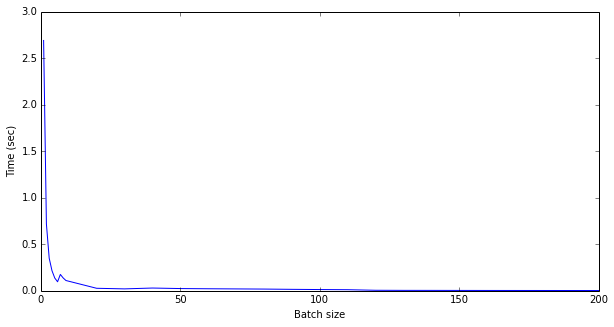

In [22]:
plt.plot(m1[:,0], m1[:,1]/m1[:,0]/m1[:,2])
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')

In [15]:
def detect_beats(
    ecg,  # The raw ECG signal
    rate,  # Sampling rate in HZ
    # Window size in seconds to use for
    ransac_window_size=5.0,
    # Low frequency of the band pass filter
    lowfreq=5.0,
    # High frequency of the band pass filter
    highfreq=15.0,
):
    """
    ECG heart beat detection based on
    http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
    with some tweaks (mainly robust estimation of the rectified signal
    cutoff threshold).
    """

    ransac_window_size = int(ransac_window_size * rate)

    lowpass = signal.butter(1, highfreq / (rate / 2.0), 'low')
    highpass = signal.butter(1, lowfreq / (rate / 2.0), 'high')
    # TODO: Could use an actual bandpass filter
    ecg_low = signal.filtfilt(*lowpass, x=ecg)
    ecg_band = signal.filtfilt(*highpass, x=ecg_low)

    # Square (=signal power) of the first difference of the signal
    decg = np.diff(ecg_band)
    decg_power = decg**2

    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(len(decg_power) // ransac_window_size):
        sample = slice(i * ransac_window_size, (i + 1) * ransac_window_size)
        d = decg_power[sample]
        thresholds.append(0.5 * np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5 * np.std(decg_power)
    threshold = np.median(thresholds)
    max_power = np.median(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power /= max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2

    shannon_energy = -square_decg_power * np.log(square_decg_power)
    shannon_energy[~np.isfinite(shannon_energy)] = 0.0

    mean_window_len = int(rate * 0.125 + 1)
    lp_energy = np.convolve(
        shannon_energy, [
            1.0 / mean_window_len] * mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)

    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate / 8.0)
    lp_energy_diff = np.diff(lp_energy)

    zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    zero_crossings = np.flatnonzero(zero_crossings)
    zero_crossings -= 1
    return zero_crossings

In [16]:
def loadmat(id):
    fname = "../validation/A%05d.mat"%id
    y_val = io.loadmat(fname)['val'][0]
    return y_val

In [17]:
time_sum = 0
for i in range(100):
    data1 = loadmat(np.random.randint(1,200))
    t = time()
    detect_beats(data1, fs)
    time_sum += time()-t
print(time_sum/100)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


0.00448775053024292
